# SeqRep Test

## Preprocessing

In [1]:
from SeqRep.dataset_builder import DatasetBuilder, SILVAHeaderParser
builder = DatasetBuilder(SILVAHeaderParser())
dataset = builder.from_fasta(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'])
# dataset = builder.from_fasta(['small.fasta'])

In [3]:
dataset['raw_headers']

0         AY846379.1.1791 Eukaryota;Archaeplastida;Chlor...
1         AB001445.1.1538 Bacteria;Proteobacteria;Gammap...
2         AY929368.1.1768 Eukaryota;Archaeplastida;Chlor...
3         KM209255.204.1909 Bacteria;Proteobacteria;Gamm...
4         AY955002.1.1727 Eukaryota;Archaeplastida;Chlor...
                                ...                        
510503    MVBC01000034.3.1520 Bacteria;Bacteroidota;Bact...
510504    JQIO01000430.1097739.1099039 Bacteria;Cyanobac...
510505    JQHZ01065714.557.1975 Bacteria;Cyanobacteria;C...
510506    JQIN01002109.43002.44826 Eukaryota;Archaeplast...
510507    KY979510.1.1479 Bacteria;Actinobacteriota;Acti...
Name: raw_headers, Length: 510508, dtype: object

In [ ]:
dataset[dataset['raw_headers'].apply(lambda i: len(i.split(' ')[1:]))]

In [2]:
dataset = dataset.drop_bad_headers()
len(dataset)

334360

In [3]:
kmer_counts = dataset.count_kmers(5, jobs=7, chunksize=1000)

In [4]:
dataset.trim_seqs(1500)

## Simple Dense Network

In [28]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(512)
builder.dense(512)
builder.dense(512)
dense_model = builder.compile(output_dim=2)
dense_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 1,051,138
Trainable params: 1,051,138
Non-tra

In [29]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
dense_comp = ComparativeEncoder(dense_model, dist=Euclidean())

In [39]:
dense_comp.fit(kmer_counts, batch_size=100, epochs=7, jobs=7, chunksize=500)

Epoch 1:


100%|████████████████████| 334360/334360 [00:16<00:00, 20467.21it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2073
Epoch time: 66.18736982345581
Epoch 2:


100%|████████████████████| 334360/334360 [00:15<00:00, 21931.15it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2076
Epoch time: 65.42476606369019
Epoch 3:


100%|████████████████████| 334360/334360 [00:15<00:00, 20970.10it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2072
Epoch time: 65.47609329223633
Epoch 4:


100%|████████████████████| 334360/334360 [00:15<00:00, 21226.45it/s]


3344/3344 [==============================] - 43s 13ms/step - loss: 0.2055
Epoch time: 68.72371792793274
Epoch 5:


100%|████████████████████| 334360/334360 [00:17<00:00, 19502.29it/s]


3344/3344 [==============================] - 46s 14ms/step - loss: 0.2045
Epoch time: 71.64712715148926
Epoch 6:


100%|████████████████████| 334360/334360 [00:17<00:00, 19264.74it/s]


3344/3344 [==============================] - 45s 13ms/step - loss: 0.2044
Epoch time: 70.66919183731079
Epoch 7:


100%|████████████████████| 334360/334360 [00:16<00:00, 19878.29it/s]


3344/3344 [==============================] - 44s 13ms/step - loss: 0.2037
Epoch time: 69.23326396942139


In [40]:
dense_comp.save('Models/densenet')

In [5]:
from SeqRep.comparative_encoder import ComparativeEncoder
dense_comp = ComparativeEncoder.load('Models/densenet')

Metal device set to: Apple M1 Pro


2023-02-28 21:39:58.852430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 21:39:58.852570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
dense_reprs = dense_comp.transform(kmer_counts, batch_size=100)

  26/3344 [..............................] - ETA: 6s  

2023-02-28 21:40:00.652081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-28 21:40:00.699339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 6s 2ms/step


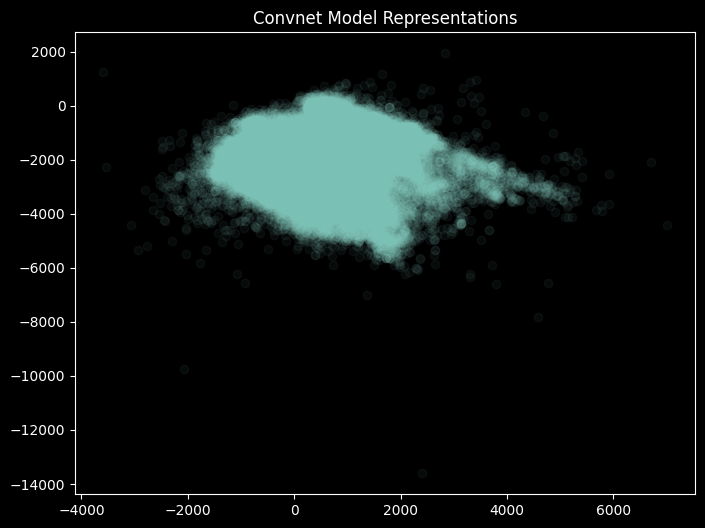

In [42]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(dense_reprs, "Dense Model Representations")

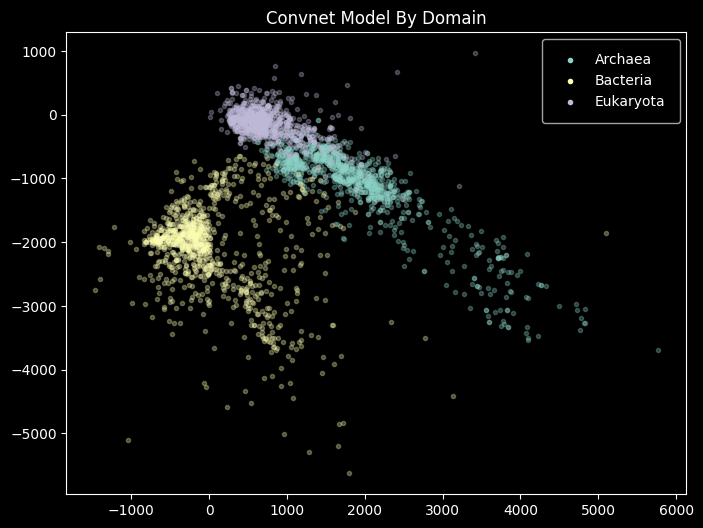

In [168]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(dense_reprs, dataset, 'Domain', 'Convnet Model By Domain', marker='.')

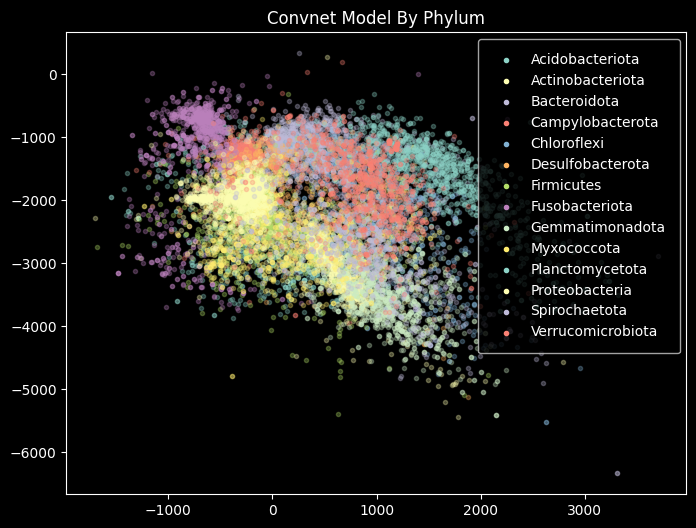

In [167]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(dense_reprs, dataset, 'Phylum', 'Convnet Model By Phylum', filter=1000, mask=mask, marker='.')

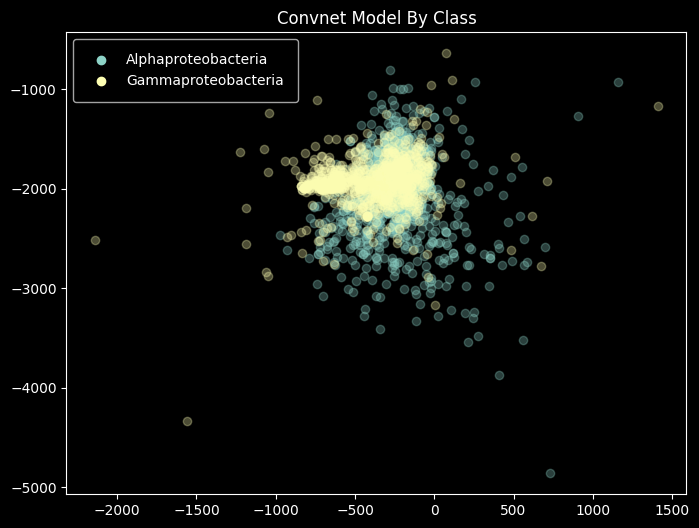

In [45]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(dense_reprs, dataset, 'Class', 'Dense Model By Class', filter=1000, mask=mask)

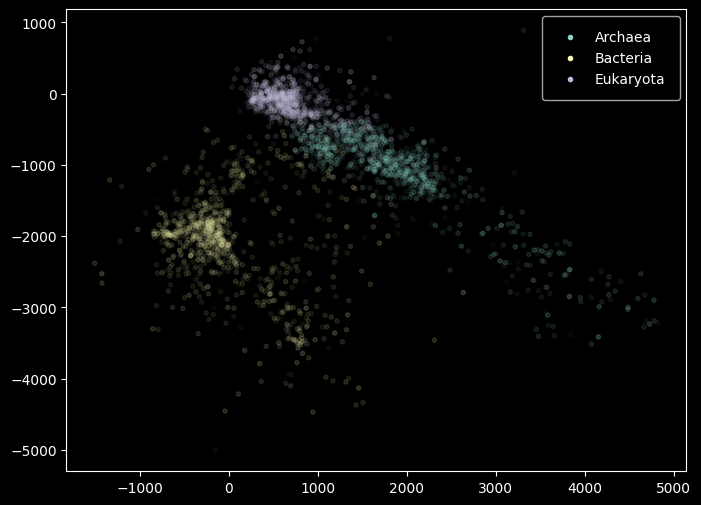

In [7]:
from SeqRep.visualize import comparative_scatter

archaea = dense_reprs[dataset['tax'].tax_mask('Domain', 'Archaea')]
bacteria = dense_reprs[dataset['tax'].tax_mask('Domain', 'Bacteria')]
eukaryota = dense_reprs[dataset['tax'].tax_mask('Domain', 'Eukaryota')]

comparative_scatter([('Archaea', archaea), ('Bacteria', bacteria), ('Eukaryota', eukaryota)],
                   sample_size=1000, marker='.')

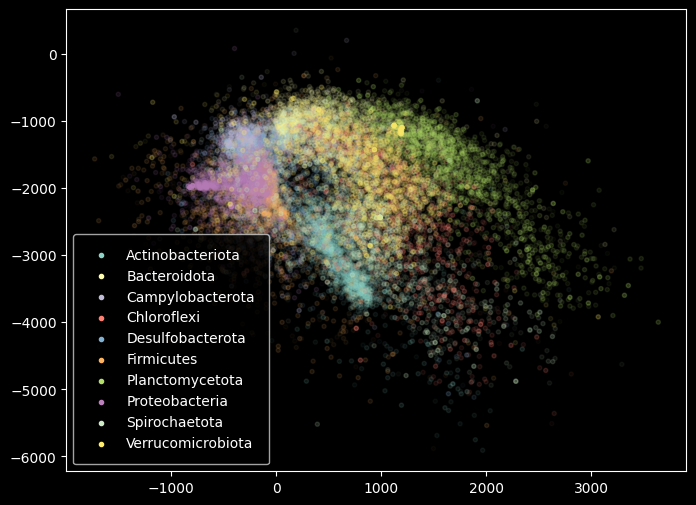

In [9]:
import numpy as np

filter_amount = 3000

uniques, counts = np.unique([i[1] for i in dataset['tax'][dataset['tax'].tax_mask('Domain', 'Bacteria')]], return_counts=True)

plottable = uniques[counts > filter_amount]

tax_mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
to_plot = dataset[tax_mask]
to_plot_seqs = dense_reprs[tax_mask]
x = []
for i in plottable:
    arr = to_plot_seqs[to_plot['tax'].tax_mask('Phylum', i)]
    x.append((i, arr))

comparative_scatter(x, sample_size=filter_amount, marker='.')

## ConvNet

In [6]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.embeddings(1)
builder.conv1D(64, 4, 64)
conv_model = builder.compile(output_dim=2)
conv_model.summary()

(256, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 reshape (Reshape)           (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 253, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 126, 64)          0         
 )                                                               
                                                    

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
conv_comp = ComparativeEncoder(conv_model, dist=Euclidean())

In [7]:
conv_comp.fit(kmer_counts, batch_size=100, epochs=6, jobs=7, chunksize=500)

Epoch 1:


100%|████████████████████| 334360/334360 [00:13<00:00, 25085.21it/s]
2023-01-04 21:03:47.078324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 21:03:47.078892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2314
Epoch time: 78.69913291931152
Epoch 2:


100%|████████████████████| 334360/334360 [00:12<00:00, 26183.80it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2185
Epoch time: 78.2213728427887
Epoch 3:


100%|████████████████████| 334360/334360 [00:12<00:00, 26259.58it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2136
Epoch time: 77.88945603370667
Epoch 4:


100%|████████████████████| 334360/334360 [00:13<00:00, 25530.49it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2101
Epoch time: 78.13169622421265
Epoch 5:


100%|████████████████████| 334360/334360 [00:13<00:00, 24784.20it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2096
Epoch time: 78.78330111503601
Epoch 6:


100%|████████████████████| 334360/334360 [00:13<00:00, 24312.21it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2067
Epoch time: 78.83666610717773


In [15]:
conv_comp.save('Models/convnet')

In [5]:
from SeqRep.comparative_encoder import ComparativeEncoder
conv_comp = ComparativeEncoder.load('Models/convnet')

Metal device set to: Apple M1 Pro


2023-01-04 19:17:45.556706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 19:17:45.556839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
conv_reprs = conv_comp.transform(kmer_counts, batch_size=100)

  44/3344 [..............................] - ETA: 7s

2023-01-04 21:17:12.712391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 9s 3ms/step


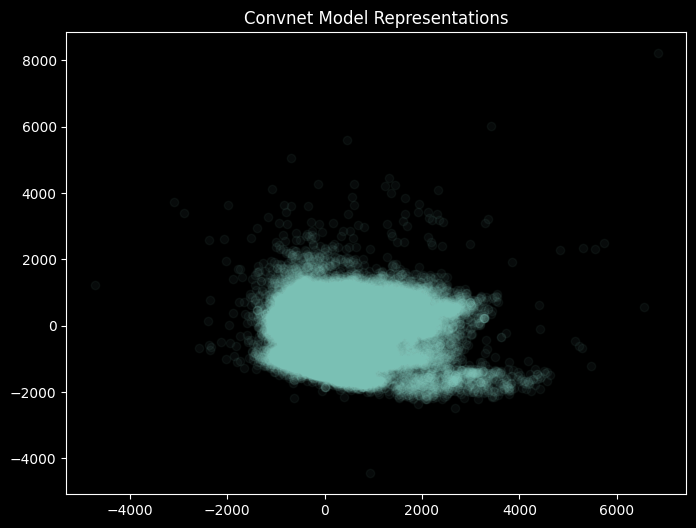

In [9]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(conv_reprs, "Convnet Model Representations")

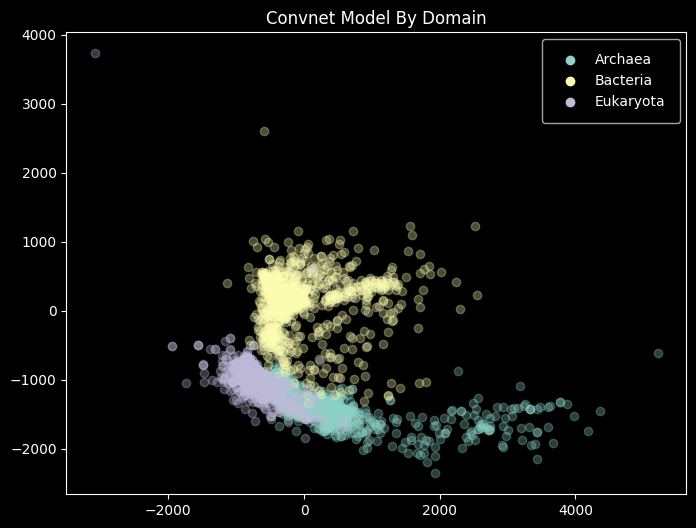

In [10]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(conv_reprs, dataset, 'Domain', 'Convnet Model By Domain')

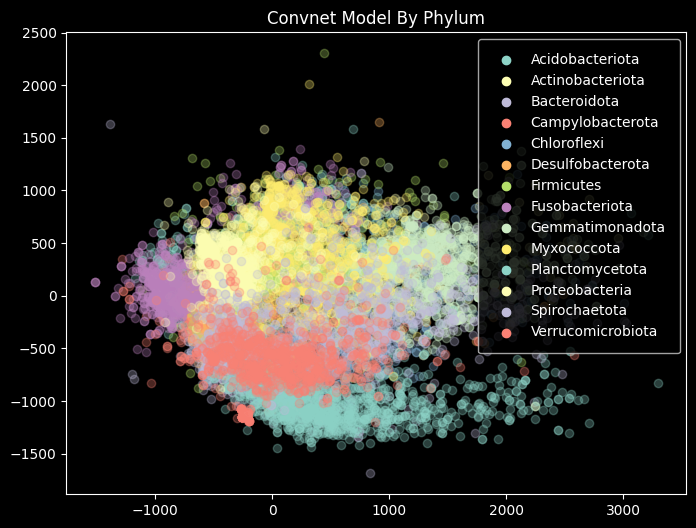

In [11]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(conv_reprs, dataset, 'Phylum', 'Convnet Model By Phylum', filter=1000, mask=mask)

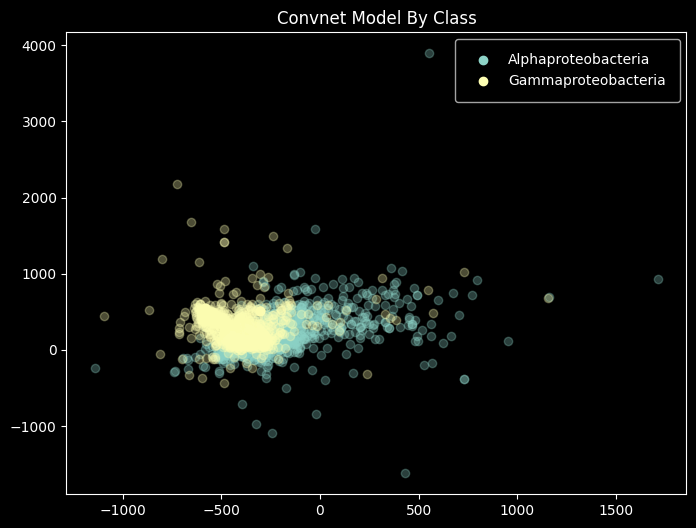

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(conv_reprs, dataset, 'Class', 'Convnet Model By Class', filter=1000, mask=mask)

## Attention Network

In [9]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.reshape((64, 4))
builder.attention(2, 128)
attn_model = builder.compile(output_dim=2)
attn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 reshape_2 (Reshape)         (None, 64, 4)             0         
                                                                 
 attention_block_1 (Attentio  (None, 64, 4)            1328      
 nBlock)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 4)            16        
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 256)               0   

In [16]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
attn_comp = ComparativeEncoder(attn_model, dist=Euclidean())

In [17]:
attn_comp.fit(kmer_counts, batch_size=100, epochs=6, jobs=7, chunksize=1000)

Epoch 1:


100%|████████████████████| 334360/334360 [00:15<00:00, 22110.53it/s]
2023-01-04 23:38:23.417353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 170s 50ms/step - loss: 0.2352
Epoch time: 197.25054597854614
Epoch 2:


100%|████████████████████| 334360/334360 [00:14<00:00, 22834.41it/s]


3344/3344 [==============================] - 166s 49ms/step - loss: 0.2209
Epoch time: 192.10749006271362
Epoch 3:


100%|████████████████████| 334360/334360 [00:14<00:00, 23314.79it/s]


3344/3344 [==============================] - 159s 47ms/step - loss: 0.2178
Epoch time: 185.16431879997253
Epoch 4:


100%|████████████████████| 334360/334360 [00:14<00:00, 23115.08it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2157
Epoch time: 181.48078107833862
Epoch 5:


100%|████████████████████| 334360/334360 [00:14<00:00, 23370.29it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2143
Epoch time: 182.39366722106934
Epoch 6:


100%|████████████████████| 334360/334360 [00:14<00:00, 23190.49it/s]


3344/3344 [==============================] - 157s 47ms/step - loss: 0.2128
Epoch time: 182.93653512001038


In [18]:
attn_comp.save('Models/attn')

In [11]:
from SeqRep.comparative_encoder import ComparativeEncoder
attn_comp = ComparativeEncoder.load('Models/attn')

In [19]:
attn_reprs = attn_comp.transform(kmer_counts, batch_size=100)

2023-01-04 23:57:41.006692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 40s 12ms/step


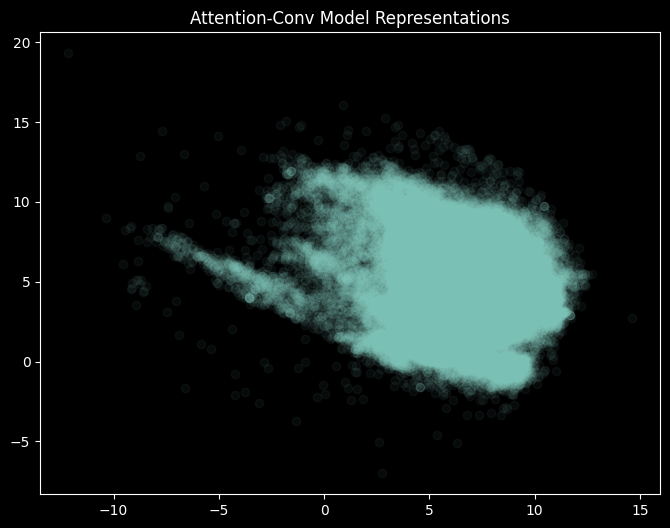

In [20]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(attn_reprs, "Attention-Conv Model Representations")

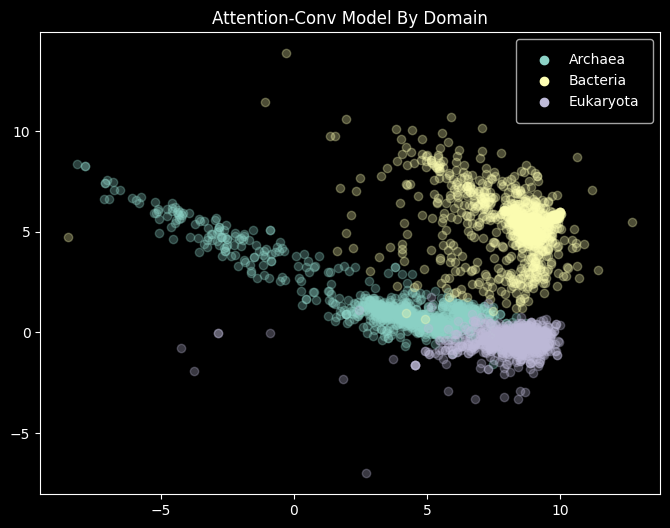

In [21]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(attn_reprs, dataset, 'Domain', 'Attention-Conv Model By Domain')

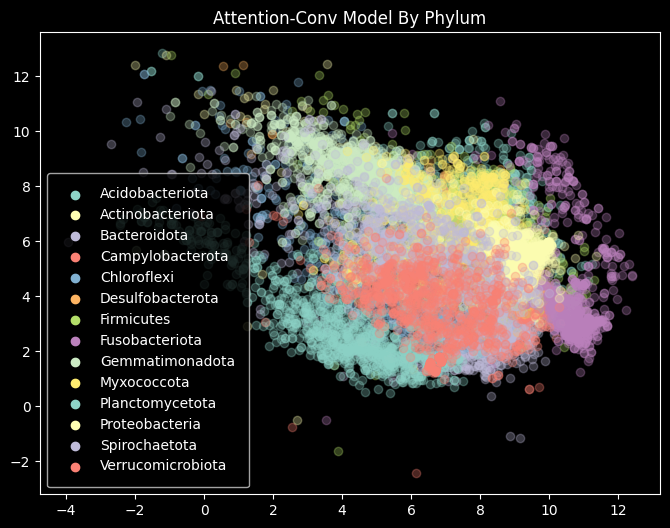

In [22]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(attn_reprs, dataset, 'Phylum', 'Attention-Conv Model By Phylum', filter=1000, mask=mask)

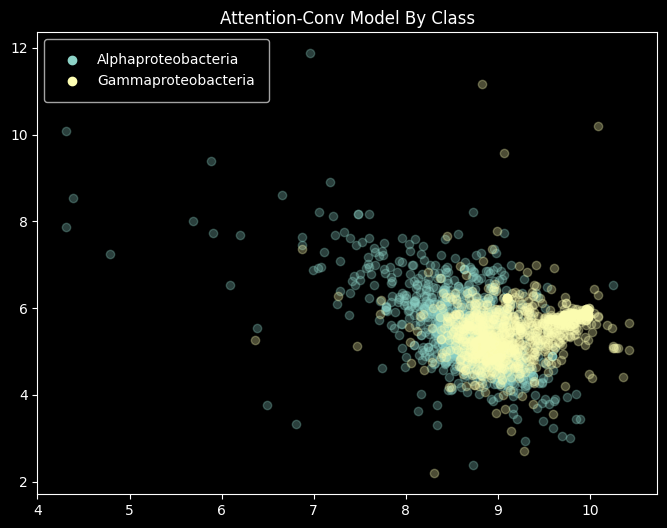

In [23]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(attn_reprs, dataset, 'Class', 'Attention-Conv Model By Class', filter=1000, mask=mask)

## Attention-Conv Network

In [15]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.embeddings(1)
builder.conv1D(64, 4, 64)
builder.embeddings(4)
builder.attention(2, 128)
attn_model = builder.compile(output_dim=2)
attn_model.summary()

(256, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_24 (Dense)            (None, 256)               262400    
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 reshape_6 (Reshape)         (None, 256, 1)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 253, 64)           320       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 126, 64)          0         
 1D)                                                             
                                                  

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
attn_comp = ComparativeEncoder(attn_model, dist=Euclidean())

In [7]:
attn_comp.fit(kmer_counts, batch_size=100, epochs=4, jobs=7, chunksize=1000)

Epoch 1:


100%|████████████████████| 334360/334360 [00:11<00:00, 27871.05it/s]
2023-01-04 23:22:36.439302: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 23:22:36.442305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 158s 47ms/step - loss: 0.2477
Epoch time: 178.37399101257324
Epoch 2:


100%|████████████████████| 334360/334360 [00:12<00:00, 26805.14it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2238
Epoch time: 176.04116916656494
Epoch 3:


100%|████████████████████| 334360/334360 [00:12<00:00, 26189.10it/s]


3344/3344 [==============================] - 157s 47ms/step - loss: 0.2218
Epoch time: 177.37169289588928
Epoch 4:


100%|████████████████████| 334360/334360 [00:12<00:00, 26902.34it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2154
Epoch time: 176.05519199371338


In [8]:
attn_comp.save('Models/attn-conv')

In [11]:
from SeqRep.comparative_encoder import ComparativeEncoder
attn_comp = ComparativeEncoder.load('Models/attn')

In [9]:
attn_reprs = attn_comp.transform(kmer_counts, batch_size=100)

2023-01-04 23:35:14.519788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 34s 10ms/step


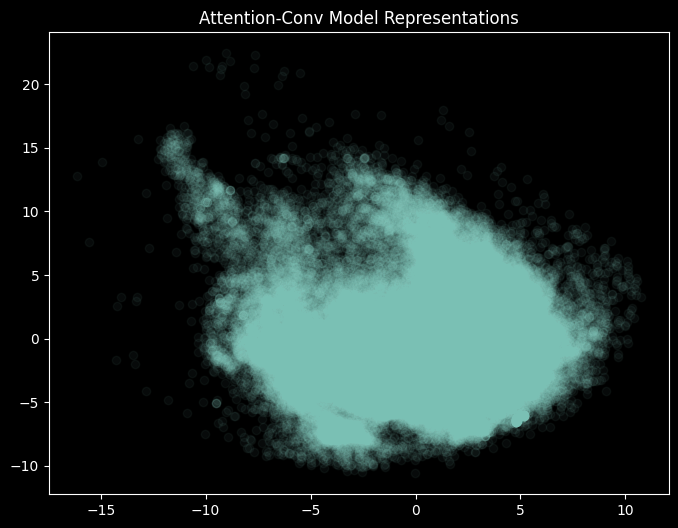

In [10]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(attn_reprs, "Attention-Conv Model Representations")

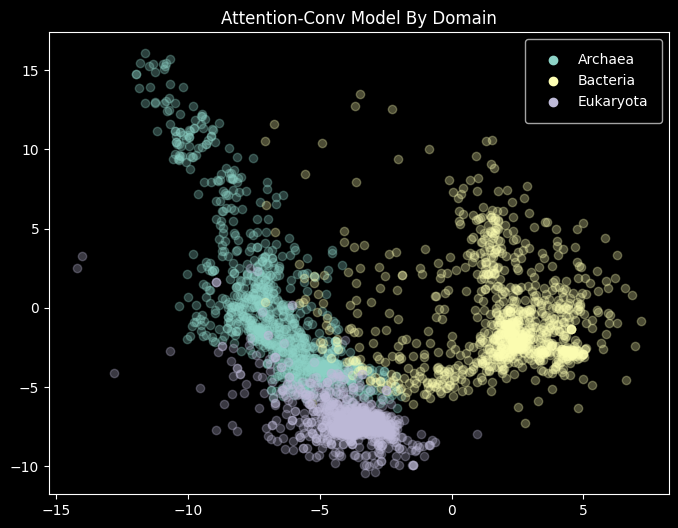

In [11]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(attn_reprs, dataset, 'Domain', 'Attention-Conv Model By Domain')

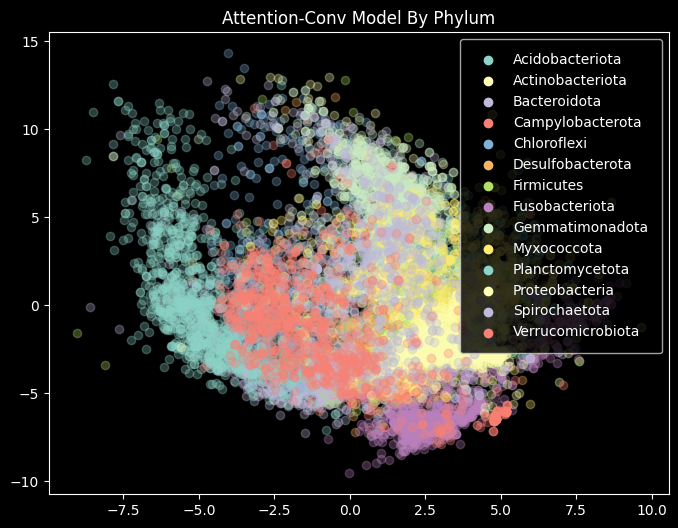

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(attn_reprs, dataset, 'Phylum', 'Attention-Conv Model By Phylum', filter=1000, mask=mask)

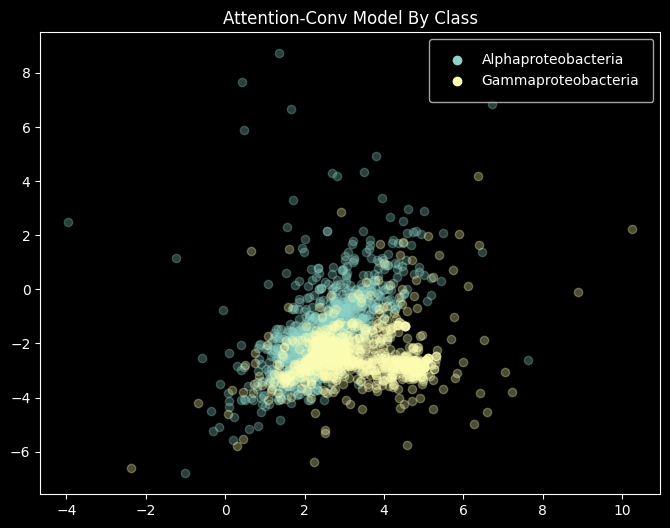

In [13]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(attn_reprs, dataset, 'Class', 'Attention-Conv Model By Class', filter=1000, mask=mask)

## Sequential Model

In [3]:
dataset.trim_seqs(300)

In [4]:
encoded = dataset.one_hot_encode(jobs=7, chunksize=50)

In [5]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(encoded.shape[1:])
builder.flatten()
builder.dense(300)
builder.reshape((75, 4))
builder.conv1D(128, 4, 128)
builder.embeddings(4)
builder.attention(2, 250)
seq_model = builder.compile(output_dim=2)
seq_model.summary()

2023-05-09 11:26:27.051495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 11:26:28.436485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-05-09 11:26:28.438755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-05-09 11:26:28.440855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 300)               450300    
                                                                 
 reshape (Reshape)           (None, 75, 4)             0         
                                                                 
 conv1d (Conv1D)             (None, 72, 128)           2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 128)          0         
 )                                                               
                                                             

In [10]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
seq_comp = ComparativeEncoder(seq_model, dist=Euclidean())

In [13]:
seq_comp.fit(encoded, batch_size=100, epochs=1, jobs=7, chunksize=500, distance_on=kmer_counts)

Epoch 1:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334360/334360 [01:15<00:00, 4409.44it/s]


0.2773063506336025


2023-02-08 16:55:13.992670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 308/3344 [=>............................] - ETA: 4:30 - loss: 0.3905

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x1799e3e20>
Traceback (most recent call last):
  File "/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x159026950>
Traceback (most recent call last):
  File "/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/eager/function.py", line 305, in __del__
    context.remove_function(self.name)
  File "/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 2740, in remove_function
    context().remove_function(name)
  File "/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
Keyb

In [ ]:
seq_comp.save('Models/seq_attn')

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
seq_comp = ComparativeEncoder.load('Models/seq_attn')

Metal device set to: Apple M1 Pro


2023-01-04 23:01:50.008607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 23:01:50.008733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
seq_reprs = seq_comp.transform(encoded, batch_size=100)

2023-01-04 23:02:08.810291: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 23:02:08.876768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 62s 19ms/step


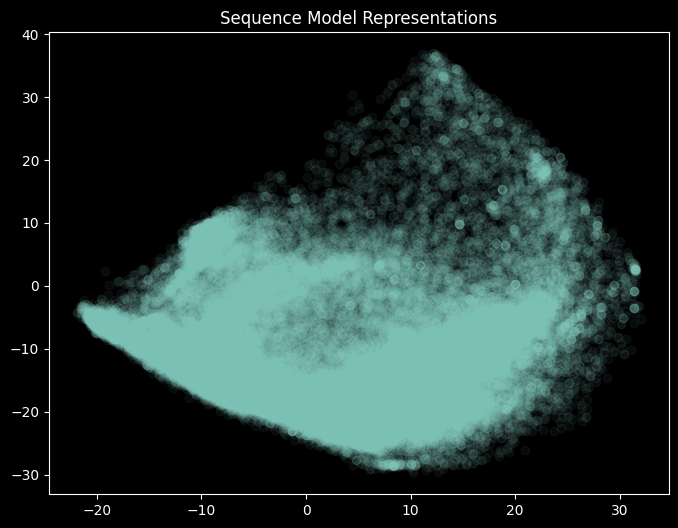

In [9]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(seq_reprs, "Sequence Model Representations")

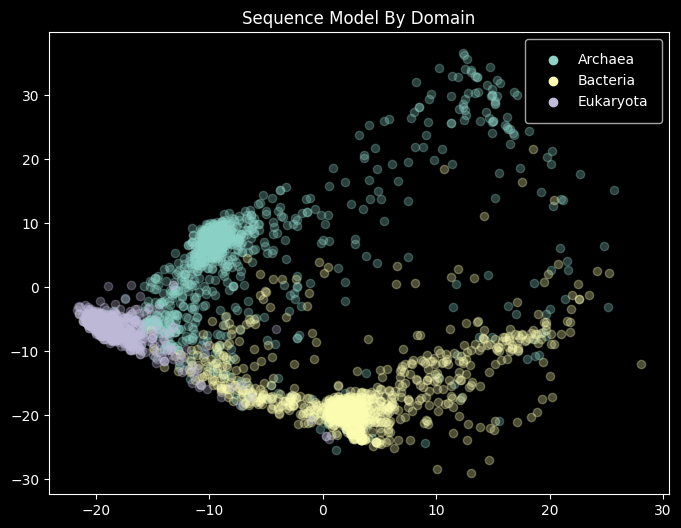

In [10]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(seq_reprs, dataset, 'Domain', 'Sequence Model By Domain')

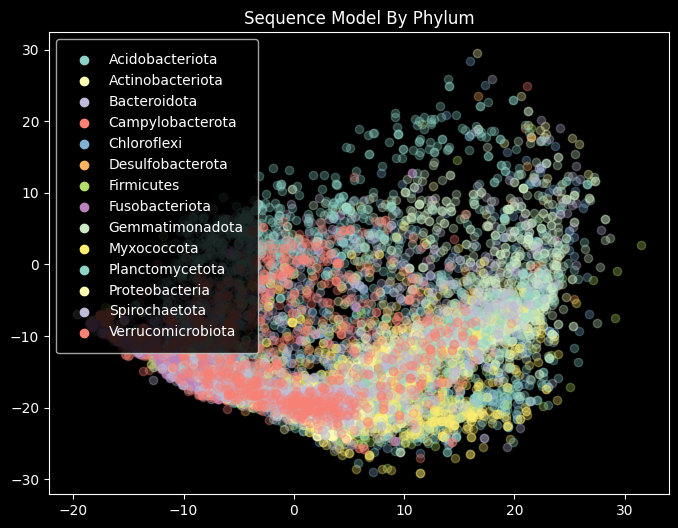

In [11]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(seq_reprs, dataset, 'Phylum', 'Sequence Model By Phylum', filter=1000, mask=mask)

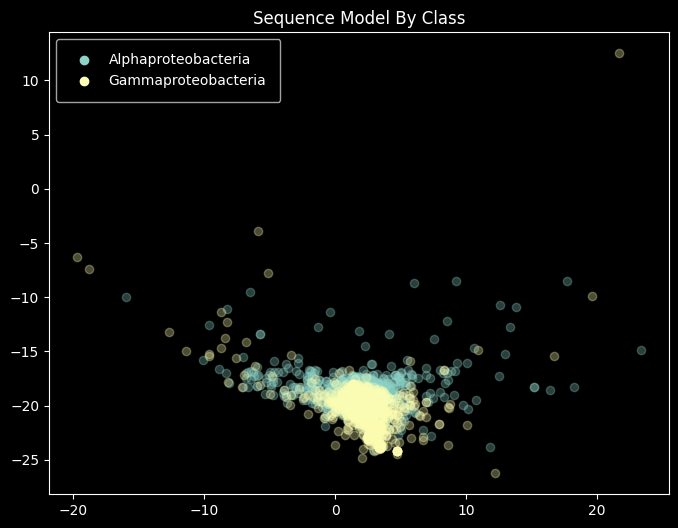

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(seq_reprs, dataset, 'Class', 'Sequence Model By Class', filter=1000, mask=mask)

## Alignment Distance

In [3]:
dataset.trim_seqs(300)
encoded = dataset.one_hot_encode(jobs=127, chunksize=100)

In [4]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(encoded.shape[1:])
builder.dense(50)
builder.reshape((100, 50 * 3))
builder.conv1D(20, 3, 100 * 50 * 3)
builder.reshape((100, 50 * 3))
builder.attention(4, 100)
builder.attention(4, 100)
builder.conv1D(20, 3, 980)
aln_model = builder.compile(output_dim=2)
aln_model.summary()

2023-05-09 12:55:09.469630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 12:55:10.780735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-05-09 12:55:10.782979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-05-09 12:55:10.784687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 dense (Dense)               (None, 300, 50)           300       
                                                                 
 reshape (Reshape)           (None, 100, 150)          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 20)            9020      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 20)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 980)               0         
                                                             

In [5]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Alignment
aln_comp = ComparativeEncoder(aln_model, dist=Alignment())

In [6]:
aln_comp.fit(encoded, batch_size=1000, epochs=10, jobs=127, chunksize=200, distance_on=dataset['seqs'].to_numpy())

Epoch 1:


100%|██████████| 334360/334360 [00:02<00:00, 143874.12it/s]
2023-05-09 12:55:30.121035: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-09 12:55:30.584230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


335/335 [==============================] - 71s 194ms/step - loss: 0.2713
Epoch time: 84.17951536178589
Epoch 2:


100%|██████████| 334360/334360 [00:02<00:00, 137576.67it/s]


335/335 [==============================] - 66s 196ms/step - loss: 0.2270
Epoch time: 83.55802774429321
Epoch 3:


100%|██████████| 334360/334360 [00:02<00:00, 147076.97it/s]


335/335 [==============================] - 65s 195ms/step - loss: 0.2241
Epoch time: 82.45276713371277
Epoch 4:


100%|██████████| 334360/334360 [00:02<00:00, 139825.66it/s]


335/335 [==============================] - 67s 201ms/step - loss: 0.2224
Epoch time: 84.90370273590088
Epoch 5:


100%|██████████| 334360/334360 [00:02<00:00, 131921.95it/s]


335/335 [==============================] - 66s 198ms/step - loss: 0.2206
Epoch time: 83.69709515571594
Epoch 6:


100%|██████████| 334360/334360 [00:02<00:00, 134196.55it/s]


335/335 [==============================] - 67s 199ms/step - loss: 0.2209
Epoch time: 83.82523798942566
Epoch 7:


100%|██████████| 334360/334360 [00:02<00:00, 130586.53it/s]


335/335 [==============================] - 66s 196ms/step - loss: 0.2205
Epoch time: 83.2289252281189
Epoch 8:


100%|██████████| 334360/334360 [00:02<00:00, 137883.36it/s]


335/335 [==============================] - 65s 195ms/step - loss: 0.2197
Epoch time: 82.67580676078796
Epoch 10:


100%|██████████| 334360/334360 [00:02<00:00, 135564.53it/s]


335/335 [==============================] - 66s 198ms/step - loss: 0.2199
Epoch time: 83.92034316062927


In [7]:
aln_comp.save('Models/aln_attn')

In [7]:
from SeqRep.comparative_encoder import ComparativeEncoder
aln_comp = ComparativeEncoder.load('Models/aln_attn')

In [8]:
aln_reprs = aln_comp.transform(encoded, batch_size=1000)

335/335 [==============================] - 11s 31ms/step


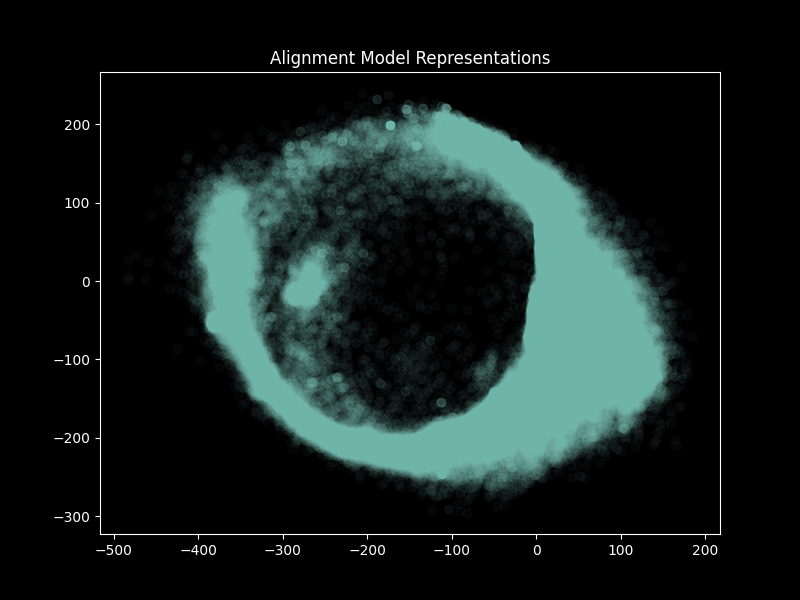

In [9]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(aln_reprs, "Alignment Model Representations", alpha=.03, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

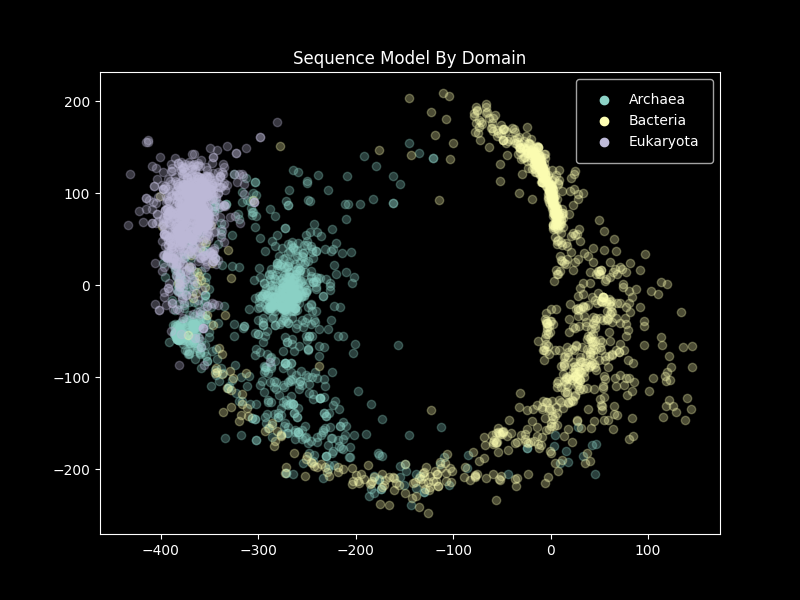

In [10]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(aln_reprs, dataset, 'Domain', 'Sequence Model By Domain', savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

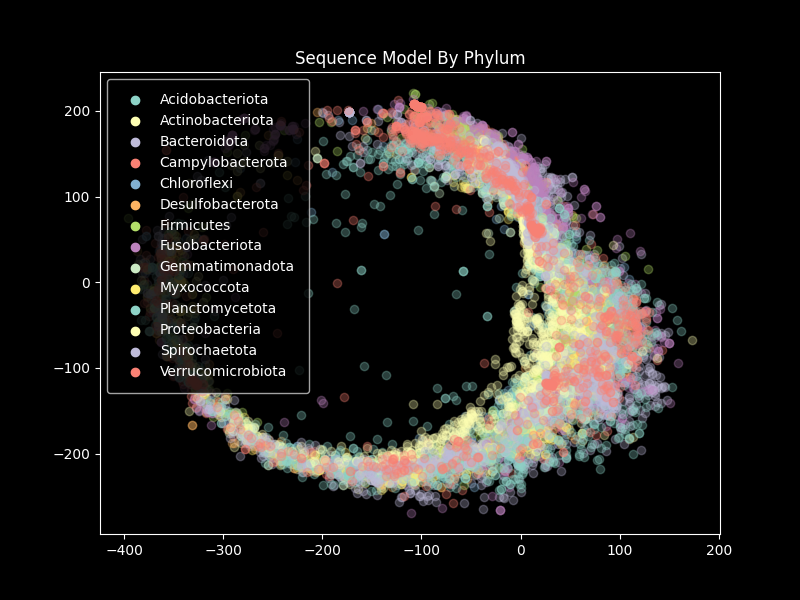

In [11]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(aln_reprs, dataset, 'Phylum', 'Sequence Model By Phylum', filter=1000, mask=mask, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

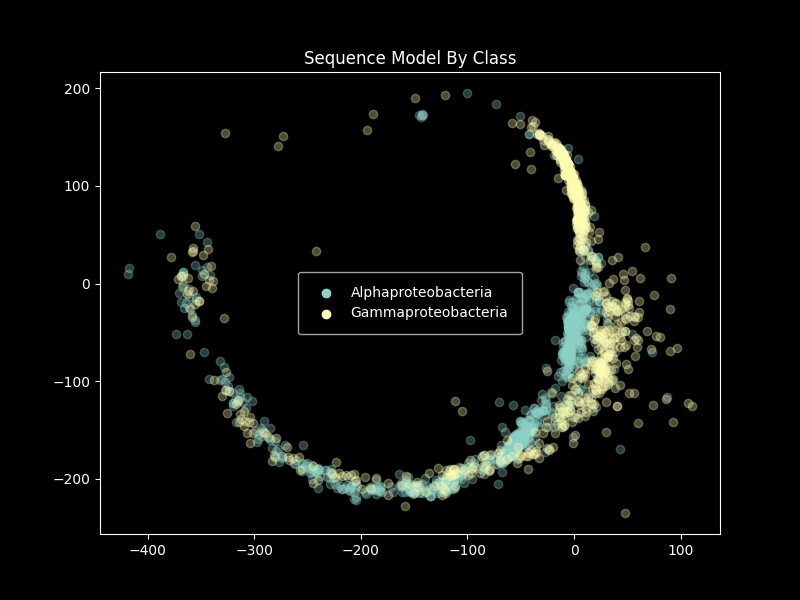

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(aln_reprs, dataset, 'Class', 'Sequence Model By Class', filter=1000, mask=mask, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

## With KMer Sequences

In [3]:
kmers = dataset.gen_kmer_seqs(2, jobs=64, chunksize=100, trim_to=300)

100%|██████████| 334360/334360 [00:03<00:00, 86892.29it/s] 


In [4]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(kmers.shape[1:])
builder.dense(50)
builder.reshape((100, 50 * 3))
builder.conv1D(20, 3, 100 * 50 * 3)
builder.reshape((100, 50 * 3))
builder.attention(4, 100)
builder.attention(4, 100)
builder.conv1D(20, 3, 980)
aln_model = builder.compile(output_dim=2)
aln_model.summary()

2023-05-09 13:20:10.685756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 13:20:12.229270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-05-09 13:20:12.231538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-05-09 13:20:12.233467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 16)]         0         
                                                                 
 dense (Dense)               (None, 300, 50)           850       
                                                                 
 reshape (Reshape)           (None, 100, 150)          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 20)            9020      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 20)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 980)               0         
                                                             

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Alignment
aln_comp = ComparativeEncoder(aln_model, dist=Alignment())

In [7]:
aln_comp.fit(kmers, batch_size=1000, epochs=10, jobs=127, chunksize=200,
             distance_on=dataset['seqs'].apply(lambda i: i[:350]).to_numpy())

Epoch 1:


100%|██████████| 334360/334360 [00:03<00:00, 110275.70it/s]
2023-05-09 13:20:50.084573: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-09 13:20:50.547912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


335/335 [==============================] - 73s 198ms/step - loss: 0.2340
Epoch time: 94.9663953781128
Epoch 2:


100%|██████████| 334360/334360 [00:03<00:00, 99480.01it/s] 


335/335 [==============================] - 67s 199ms/step - loss: 0.1916
Epoch time: 97.50124430656433
Epoch 3:


100%|██████████| 334360/334360 [00:03<00:00, 107134.37it/s]


335/335 [==============================] - 67s 200ms/step - loss: 0.1888
Epoch time: 96.42389726638794
Epoch 4:


100%|██████████| 334360/334360 [00:02<00:00, 113711.78it/s]


335/335 [==============================] - 66s 198ms/step - loss: 0.1866
Epoch time: 95.75346231460571
Epoch 5:


100%|██████████| 334360/334360 [00:03<00:00, 100433.16it/s]


335/335 [==============================] - 67s 199ms/step - loss: 0.1864
Epoch time: 96.01329040527344
Epoch 6:


100%|██████████| 334360/334360 [00:03<00:00, 111182.22it/s]


335/335 [==============================] - 67s 201ms/step - loss: 0.1860
Epoch time: 96.3827178478241
Epoch 7:


100%|██████████| 334360/334360 [00:03<00:00, 111113.98it/s]


335/335 [==============================] - 67s 198ms/step - loss: 0.1859
Epoch time: 95.89958333969116
Epoch 8:


100%|██████████| 334360/334360 [00:02<00:00, 112101.81it/s]


335/335 [==============================] - 67s 201ms/step - loss: 0.1863
Epoch time: 96.66735100746155
Epoch 9:


100%|██████████| 334360/334360 [00:03<00:00, 106239.78it/s]


335/335 [==============================] - 67s 200ms/step - loss: 0.1848
Epoch time: 94.16607570648193
Epoch 10:


100%|██████████| 334360/334360 [00:03<00:00, 110568.75it/s]


335/335 [==============================] - 67s 199ms/step - loss: 0.1849
Epoch time: 95.77476572990417


In [8]:
aln_comp.save('Models/aln_attn_kmers')

In [ ]:
from SeqRep.comparative_encoder import ComparativeEncoder
aln_comp = ComparativeEncoder.load('Models/aln_attn_kmers')

In [9]:
aln_reprs = aln_comp.transform(kmers, batch_size=1000)

335/335 [==============================] - 11s 32ms/step


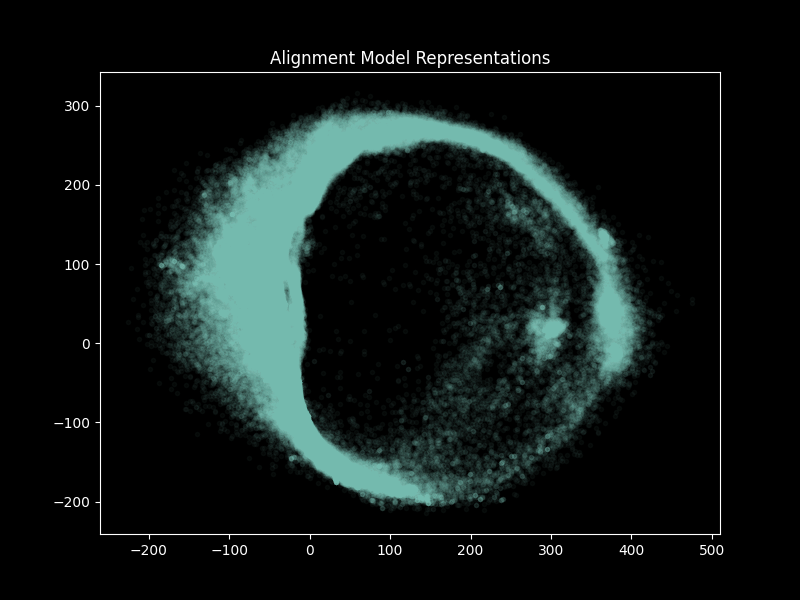

In [20]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(aln_reprs, "Alignment Model Representations", alpha=.04, savepath='out.png', marker='.')
from IPython.display import Image
Image(filename='out.png')

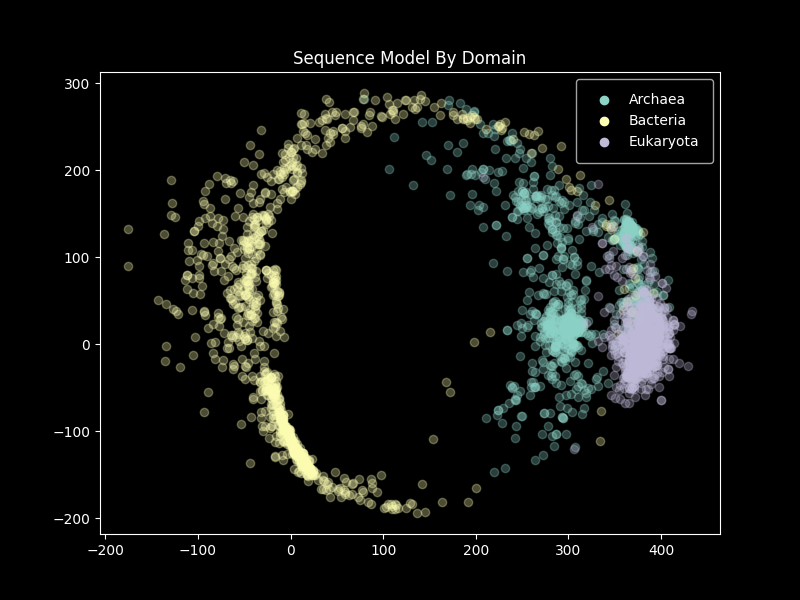

In [22]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(aln_reprs, dataset, 'Domain', 'Sequence Model By Domain', savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

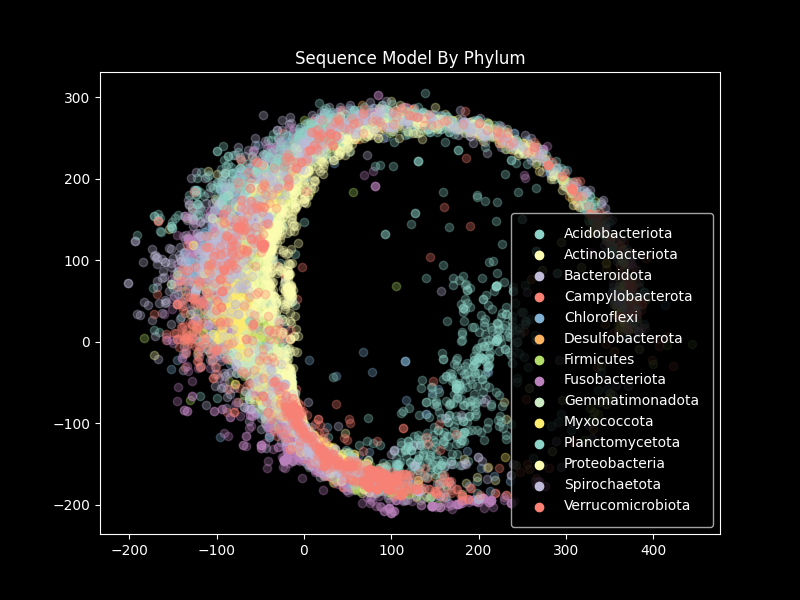

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(aln_reprs, dataset, 'Phylum', 'Sequence Model By Phylum', filter=1000, mask=mask, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

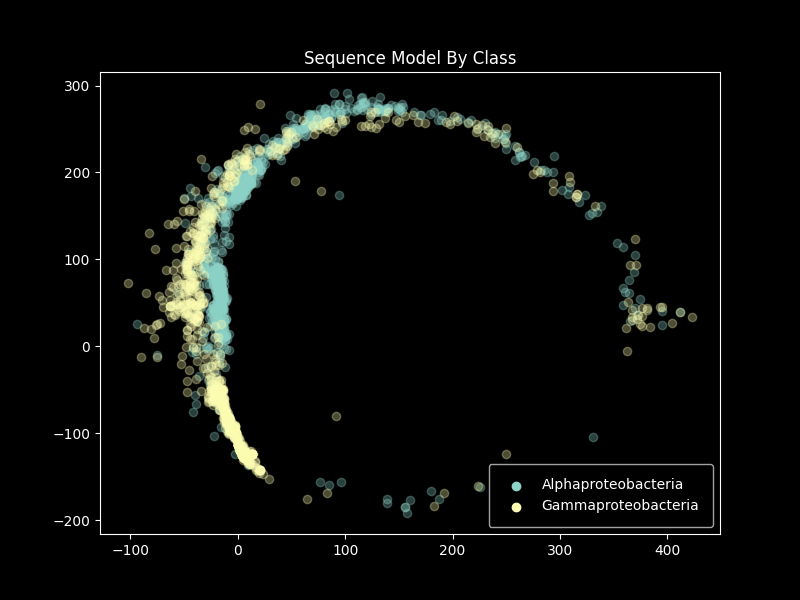

In [13]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(aln_reprs, dataset, 'Class', 'Sequence Model By Class', filter=1000, mask=mask, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')